In [125]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import sqlite3
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
%matplotlib inline

In [126]:
conn = sqlite3.connect('bosh.db')
c = conn.cursor()

In [182]:
sales = pd.read_sql('select * from sales where item_id = 362 and store_id = 0', con = conn)

In [183]:
dates = pd.read_sql('select * from dates', con = conn).set_index('date_id')

In [184]:
sales_df = sales.merge(dates['date_name'], left_on = 'date_id', right_index = True).reset_index()
sales_df['date_name'] = sales_df['date_name'].map(lambda x: pd.to_datetime(x))

In [266]:
class Series:
    def __init__(self, df, valcol):
        self.df = df
        self.columns = list(df.columns)
        self.valcol = valcol
        self.tseries = df[valcol]
        self.stand_tseries = df[]
        self.length = len(df[valcol])
        self.description = df[valcol].describe()
        
    def plot_series(self, idx_range, **subplkwargs):
        plot_range = idx_range
        fig, ax = plt.subplots(**subplkwargs)
        ax.plot(tseries[plot_range])
        
    def plot_forecast(self, model, back = 28, forward = 28, **subplkwargs):
        forecast, forecast_stderr, forecast_conf_int = self.model_forecast(model, forward)
        maxidx = self.tseries.index[-1]
        forecast.index = pd.RangeIndex(maxidx + 1, maxidx + 1 + forward)
        plot_df = pd.DataFrame(self.tseries[-back:].append(forecast)).rename({0:'Sales'}, axis = 1)
        plot_df.loc[forecast.index, 'Type'] = 'Forecast'
        plot_df['Type'].fillna('Historic', inplace = True)
        plot_df['forecast_conf_int_lower'], plot_df['forecast_conf_int_upper'] = plot_df['Sales'], plot_df['Sales']
        plot_df.loc[forecast.index, 'forecast_conf_int_lower'] = forecast_conf_int['conf_int_lower'].values
        plot_df.loc[forecast.index, 'forecast_conf_int_upper'] = forecast_conf_int['conf_int_upper'].values
        fig, ax = plt.subplots(**subplkwargs)
        ax.plot(plot_df[plot_df['Type'] == 'Historic']['Sales'], color = 'black')
        ax.plot(plot_df[plot_df['Type'] == 'Forecast']['Sales'], color = 'green')
        ax.fill_between(plot_df.index, plot_df['forecast_conf_int_lower'], plot_df['forecast_conf_int_upper'], alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
        
    def plot_acf(self, lags = [0,365], **subplkwargs):
        fig, ax = plt.subplots(**subplkwargs)
        autocorrelation_plot(sales[self.valcol], ax = ax)
        ax.set_xlim(lags)
        
    def model_arima(self, p=7, d=1, q=0):
        model = ARIMA(self.tseries, order=(p,d,q))
        model_fit = model.fit(disp=0)
        self.arima_model = model
        self.arima_model_fit = model_fit
        return(model, model_fit)
    
    def model_forecast(self, model, forward = 28):
        forecast, forecast_stderr, forecast_conf_int = model_fit.forecast(forward)
        forecast = pd.Series(forecast)
        forecast_stderr = pd.Series(forecast_stderr)
        forecast_conf_int = pd.DataFrame(forecast_conf_int).rename({0:'conf_int_lower', 1:'conf_int_upper'}, axis = 1)
        maxidx = tseries.index[-1]
        forecast.index = pd.RangeIndex(maxidx + 1, maxidx + 1 + forward)
        self.forecast = forecast
        self.forecast_stderr = forecast_stderr
        self.forecast_conf_int = forecast_conf_int
        return(forecast, forecast_stderr, forecast_conf_int)
    
    
    ###PROPHET FUNC
        
        
        
        


In [267]:
s = Series(sales_df, 'sales_count')
s.df.head()

,index,sale_id,sale_name,item_id,department_id,category_id,store_id,state_id,date_id,sales_count,date_name
0,0,363,HOBBIES_1_371_CA_1_validation,362,0,0,0,0,0,14,2011-01-29
1,1,30853,HOBBIES_1_371_CA_1_validation,362,0,0,0,0,1,25,2011-01-30
2,2,61343,HOBBIES_1_371_CA_1_validation,362,0,0,0,0,2,67,2011-01-31
3,3,91833,HOBBIES_1_371_CA_1_validation,362,0,0,0,0,3,27,2011-02-01
4,4,122323,HOBBIES_1_371_CA_1_validation,362,0,0,0,0,4,0,2011-02-02


In [268]:
model = s.model_arima()

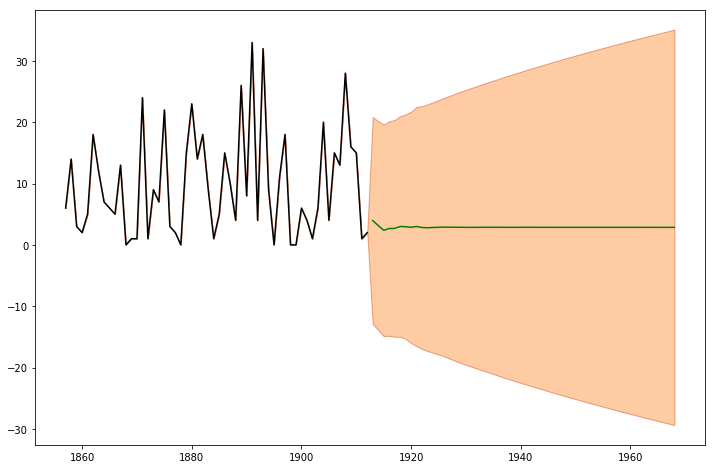

In [269]:
s.plot_forecast(model, back = 56, forward = 56, **{'figsize': (12,8)})